In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df = pd.read_csv('datasets/nlp/news1.csv', usecols=['text', 'date', 'event'])
df.sort_values(by=['event'], inplace=True)
df.head()

,text,date,event
650,"Яндекс.Новости (news.yandex.ru), Москва, 31 ма...",2017-03-31,SpaceX запустила и посадила ракету
672,"Top Real Estate (topre.ru), Москва, 31 марта 2...",2017-03-31,SpaceX запустила и посадила ракету
671,"Kremlin Press (kremlinpress.com), Москва, 31 м...",2017-03-31,SpaceX запустила и посадила ракету
670,"РБК (rbc.ru), Москва, 31 марта 2017 SPACEX ВПЕ...",2017-03-31,SpaceX запустила и посадила ракету
669,"Newstes.ru, Москва, 31 марта 2017 SPACEX ВПЕРВ...",2017-03-31,SpaceX запустила и посадила ракету


In [2]:
df.event.value_counts()

Чемпионат мира по хоккею                            102
Путин и Меркель в Сочи                              100
Умер Евгений Евтушенко                              100
Теракт в Лондоне                                    100
Теракт в Барселоне                                  100
Единый день голосования                             100
Законопроект о курортных сборах                     100
Кубок конфедерации FiFA                             100
Митинг в Москве против коррупции                    100
Саммит G20                                          100
Ураган в Москве                                     100
Акции протеста 12 июня                              100
Передача РПЦ Исаакиевского собора                   100
Умер Виталий Чуркин                                  84
Парламентские выборы в Великобритании                82
Убит Денис Вороненков                                82
Горячая линия Президента Путина                      62
Фильм “Он вам не Димон”                         

In [3]:
%time
import re
from nltk.corpus import stopwords
regex = re.compile('[А-Яа-я]+')
mystopwords = stopwords.words('russian') + ['это', 'наш', 'тыс', 'млн', 'млрд', 'также', 'т', 'д']
mystoplammas = ['который', 'прошлый', 'сей', 'свой', 'наш', 'мочь', 'такой']

from pymystem3 import Mystem

m = Mystem()

def words_only(text, regex=regex):
    return ' '.join(regex.findall(text))

def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return ' '.join([token for token in text.split() if not token in mystopwords])
    except:
        return ''

def lemmatize(text, mystem=m):
    try:
        return ''.join(m.lemmatize(text)).strip()
    except:
        return ' '

def remove_stoplemmas(text, mystoplammas=mystoplammas):
    try:
        return ' '.join([token for token in text.split() if not token in mystoplammas])
    except:
        return ''
    
df.text = df.text.apply(lemmatize)
df.text = df.text.str.lower()
df.text = df.text.apply(words_only)
df.text = df.text.apply(remove_stopwords)
df.text = df.text.apply(remove_stoplemmas)

CPU times: total: 0 ns
Wall time: 0 ns


Представление данных в Gensim словарем и корпусом:

In [4]:
from gensim.corpora import *
texts = [df.text.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Вычисления сходства ко косинусной мере на векторах tf-idf:

In [5]:
%%time
from gensim.models import *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

CPU times: total: 26.8 s
Wall time: 11.2 s


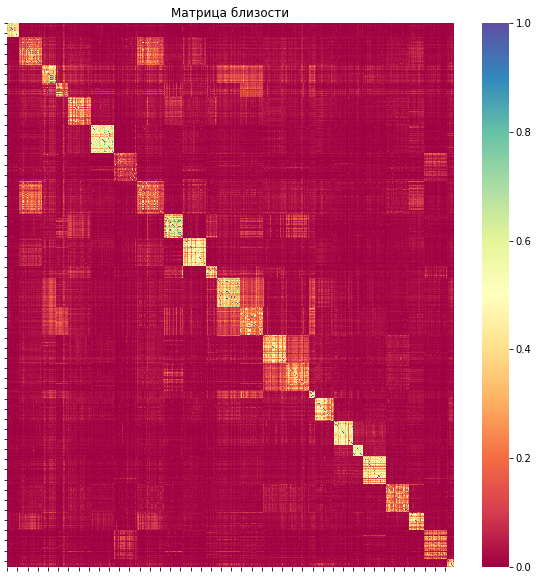

In [6]:
from pylab import pcolor, show, colorbar, xticks, yticks
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[10,10])

sns.heatmap(data=sims, cmap='Spectral').set(xticklabels=[], yticklabels=[])

plt.title('Матрица близости')
plt.show()

### Модели скрытых тем

#### Латентно-семантический анализ [LSI]
Сингулярное разложение: $M^i_k = U\sum_kV^i_k$

* M - матрица слово-документ
* U - матрица слово-тема
* k - число тем
* V - матрица документ-тема

In [7]:
%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
lsi.show_topics(5)

[(0,
  '0.226*"путин" + 0.168*"трамп" + 0.148*"меркель" + 0.133*"президент" + 0.127*"выборы" + 0.116*"курортный" + 0.113*"навальный" + 0.112*"акция" + 0.109*"теракт" + 0.102*"собор"'),
 (1,
  '0.550*"курортный" + 0.466*"сбор" + 0.235*"законопроект" + 0.212*"эксперимент" + 0.158*"инфраструктура" + 0.148*"введение" + 0.130*"вносить" + 0.119*"крым" + 0.119*"край" + 0.111*"алтайский"'),
 (2,
  '0.394*"собор" + 0.295*"исаакиевский" + 0.228*"передача" + -0.227*"путин" + 0.225*"рпц" + 0.212*"акция" + -0.210*"меркель" + -0.161*"трамп" + 0.149*"петербург" + 0.146*"навальный"'),
 (3,
  '-0.322*"теракт" + 0.262*"собор" + -0.250*"барселона" + 0.195*"исаакиевский" + 0.175*"путин" + 0.174*"меркель" + -0.171*"лондон" + 0.152*"передача" + 0.148*"рпц" + -0.137*"евтушенко"'),
 (4,
  '0.490*"евтушенко" + 0.326*"чуркин" + 0.317*"поэт" + 0.247*"евгений" + 0.159*"виталий" + 0.158*"умирать" + -0.154*"партия" + 0.133*"оон" + -0.133*"теракт" + -0.116*"великобритания"')]

Как снижение размерности влияет на матрицу близости:

In [ ]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims = (sims + 1) / 2.
plt.figure(firsize=(10, 10))
sns.heatmap(data=sims, cmap='Spectral').set(xtickslabels=[], yticklabels=[])
plt.title('Матрица близости')
plt.show()

#### Главные компоненты

In [ ]:
X = [0] * len(df)
Y = [0] * len(df)
for i in range(len(df)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    try:
        for topic in LSI_topics:
            if topic[0] == 0:
                X[i] = topic[1]
            elif topic[0] == 1:
                Y[i] = topic[1]
    except:
        pass

vis_df = pd.DataFrame({'X': X, 'X': Y, 'topic': df.event})

In [ ]:
sns.FactsGrid(vis_df, hue='topic', size=10).map(plt.scatter, 'X', 'Y').add_legend()

### Латентное размещение Дирихле [LDA]

Генеративная модель порождения документа, оценивает распределение тем по документам и слов по темам: <br>
p(слово|документ)= $\sum_{тема}P(документ|тема)P(слово|тема)$